# Notebook to test the effect of adding a null class to NN

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random

In [3]:
batch_size = 128
num_classes = 10
epochs = 20
n_classes = 10

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.8, random_state=2019, stratify=y_train)
x_train, x_val, x_test = x_train / 255.0, x_val / 255.0, x_test / 255.0

y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_val = tf.keras.utils.to_categorical(y_val, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_val = x_val.reshape(x_val.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

In [4]:
print(x_train.shape, x_val.shape)

(48000, 28, 28, 1) (12000, 28, 28, 1)


In [5]:
# Create the model
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(28,28,1)))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,(3, 3)))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

# Fully connected layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(10))

model.add(Activation('softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 24, 24, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0

In [7]:
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_val, y_val),
          callbacks=[EarlyStopping(monitor='val_accuracy', mode='auto', verbose=1, patience=5)])

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/20
375/375 [==============================] - 4s 11ms/step - loss: 0.0940 - accuracy: 0.9720 - val_loss: 2.3918 - val_accuracy: 0.3064
Epoch 2/20
375/375 [==============================] - 4s 10ms/step - loss: 0.0317 - accuracy: 0.9900 - val_loss: 0.0594 - val_accuracy: 0.9810
Epoch 3/20
375/375 [==============================] - 4s 10ms/step - loss: 0.0198 - accuracy: 0.9936 - val_loss: 0.0427 - val_accuracy: 0.9874
Epoch 4/20
375/375 [==============================] - 4s 10ms/step - loss: 0.0156 - accuracy: 0.9952 - val_loss: 0.0445 - val_accuracy: 0.9868
Epoch 5/20
375/375 [==============================] - 4s 10ms/step - loss: 0.0137 - accuracy: 0.9956 - val_loss: 0.0323 - val_accuracy: 0.9914
Epoch 6/20
375/375 [==============================] - 4s 10ms/step - loss: 0.0096 - accuracy: 0.9970 - val_loss: 0.0551 - val_accuracy: 0.9838
Epoch 7/20
375/375 [==============================] - 4s 10ms/step - loss: 0.0105 - accuracy: 0.9966 - val_loss: 0.0438 - val_accuracy: 0.9864

### Now make a fake class of things that aren't numbers. 
These data will be randomly generated. We just have to assume that a letter isn't generated by chance. I would assume (naively) that this is incredibly unlikely.

This will not be included in test phase as we're interested in seeing whether the addition of a 'null' class regularises the network when training to improve performance in testing.

In [8]:
n_classes_null = 11 # Add additional class
n_training = x_train.shape[0]  # Total number of training samples
n_val = x_val.shape[0]  # Total validation samples

# Generate random training and validation data
x_null = np.random.randint(0, 255, size=(int(n_training/n_classes), 28, 28), dtype=np.uint8)
x_val_null = np.random.randint(0, 255, size=(int(n_val/n_classes), 28, 28), dtype=np.uint8)

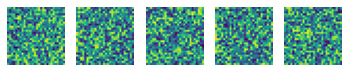

In [9]:
# Visualise some of the random data
sample_indicies = [random.randint(0, x_null.shape[0]-1) for _ in range(5)]
fig, ax = plt.subplots(1, 5, figsize=(6,2))
for i,a in enumerate(ax):
  a.imshow(x_null[sample_indicies[i]])
  a.axis('off')
plt.show()

In [10]:
# Rescale null data between 0 and 1
x_null = x_null / 255.0; x_val_null = x_val_null / 255.0

# Concatenate with regualar training data
x_null = x_null.reshape(x_null.shape[0], img_rows, img_cols, 1)
x_train_null = np.concatenate((x_train,x_null), axis=0)
x_val_null = x_val_null.reshape(x_val_null.shape[0], img_rows, img_cols, 1)
x_val_null = np.concatenate((x_val, x_val_null), axis=0)

# Create training labels
y_null = 10*np.ones((int(n_training/n_classes)), dtype=np.uint8)
y_train_null = np.concatenate(([np.argmax(i) for i in y_train],y_null))
y_train_null = tf.keras.utils.to_categorical(y_train_null, n_classes_null)
y_val_null = 10*np.ones((int(n_val/n_classes)), dtype=np.uint8)
y_val_null = np.concatenate(([np.argmax(i) for i in y_val],y_val_null),axis=0)
y_val_null = tf.keras.utils.to_categorical(y_val_null, n_classes_null)
y_test_null = tf.keras.utils.to_categorical([np.argmax(i) for i in y_test], n_classes_null)

In [11]:
# Recreate model #
model_null = Sequential()

model_null.add(Conv2D(32, (3, 3), input_shape=(28,28,1)))
model_null.add(BatchNormalization(axis=-1))
model_null.add(Activation('relu'))
model_null.add(Conv2D(32, (3, 3)))
model_null.add(BatchNormalization(axis=-1))
model_null.add(Activation('relu'))
model_null.add(MaxPooling2D(pool_size=(2,2)))

model_null.add(Conv2D(64,(3, 3)))
model_null.add(BatchNormalization(axis=-1))
model_null.add(Activation('relu'))
model_null.add(Conv2D(64, (3, 3)))
model_null.add(BatchNormalization(axis=-1))
model_null.add(Activation('relu'))
model_null.add(MaxPooling2D(pool_size=(2,2)))

model_null.add(Flatten())

# Fully connected layer
model_null.add(Dense(512))
model_null.add(BatchNormalization())
model_null.add(Activation('relu'))
model_null.add(Dropout(0.2))
model_null.add(Dense(n_classes_null))

model_null.add(Activation('softmax'))

model_null.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
model_null.fit(x_train_null, y_train_null,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          shuffle=True,  # Must shuffle as new class was just bolted onto the end
          validation_data=(x_val_null, y_val_null),
          callbacks=[EarlyStopping(monitor='val_accuracy', mode='auto', verbose=1, patience=5)])

score = model_null.evaluate(x_test, y_test_null, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/20
413/413 [==============================] - 5s 12ms/step - loss: 0.0862 - accuracy: 0.9737 - val_loss: 0.4651 - val_accuracy: 0.8602
Epoch 2/20
413/413 [==============================] - 4s 11ms/step - loss: 0.0285 - accuracy: 0.9912 - val_loss: 0.0441 - val_accuracy: 0.9868
Epoch 3/20
413/413 [==============================] - 4s 11ms/step - loss: 0.0189 - accuracy: 0.9941 - val_loss: 0.0317 - val_accuracy: 0.9908
Epoch 4/20
413/413 [==============================] - 4s 11ms/step - loss: 0.0139 - accuracy: 0.9955 - val_loss: 0.0369 - val_accuracy: 0.9893
Epoch 5/20
413/413 [==============================] - 4s 10ms/step - loss: 0.0121 - accuracy: 0.9959 - val_loss: 0.0355 - val_accuracy: 0.9894
Epoch 6/20
413/413 [==============================] - 4s 10ms/step - loss: 0.0113 - accuracy: 0.9963 - val_loss: 0.0412 - val_accuracy: 0.9880
Epoch 7/20
413/413 [==============================] - 4s 10ms/step - loss: 0.0086 - accuracy: 0.9974 - val_loss: 0.0582 - val_accuracy: 0.9836